# Lab 8


## Setup for SUSY Dataset

Use the SUSY dataset for the rest of this lab. Here is a basic setup.

In [1]:
# Our usual libraries...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
import tabulate

In [2]:
filename="../Lab.7/SUSY.csv"
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", 
          "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET",
          "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
df = pd.read_csv(filename, dtype='float64', names=VarNames)

## Scikit-Learn

[Scikit-learn](http://scikit-learn.org) is a rich python library for data science, including machine learning. For example, we can build a Fisher Discriminant (aka Linear Discriminant Analysis, or LDA). 

### Exercise 1: Install Scikit-Learn

Follow the [Installation Instructions](https://scikit-learn.org/stable/install.html) and install `scikit-learn` in your environment.

### Exercise 2: Read About Classifiers

#### Part a
Scikit-learn offers an impressively comprehensive list of machine learning algorithms. Browse through [scikit-learn's documentation](https://scikit-learn.org/stable/index.html). You'll note the algorithms are organized into classification, regression, clustering, dimensionality reduction, model selection, and preprocessing. Browse through the list of [classification algorithms](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). 

#### Part b
Note scikit-learn's documentation is rather comprehensive. The documentation on [linear models](https://scikit-learn.org/stable/modules/linear_model.html) shows how classification problems are setup. Read about the first few methods and try to comprehend the example codes. Skim the rest of the document.

#### Part c
Read through the [LDA Documentation](https://scikit-learn.org/stable/modules/lda_qda.html).


### Exercise 3: Training a Classifier

Lets' repeat what we did manually in the previous lab using scikit-learn. We'll use a LDA classifier, which we can instanciate as follows:

In [3]:
import sklearn.discriminant_analysis as DA
Fisher=DA.LinearDiscriminantAnalysis()

As discussed in the lecture, to properly formulate our problem, we'll have to:

* Define the inputs (X) vs outputs (Y)
* Designate training vs testing samples (in order to get a unbias assessment of the performance of Machine Learning algorithms)

for example, here we'll take use 4M events for training and the remainder for testing.

In [4]:
N_Train=4000000

Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:]

X_Train=Train_Sample[VarNames[1:]]
y_Train=Train_Sample["signal"]

X_Test=Test_Sample[VarNames[1:]]
y_Test=Test_Sample["signal"]

Test_sig=Test_Sample[Test_Sample.signal==1]
Test_bkg=Test_Sample[Test_Sample.signal==0]


We can train the classifier as follow:

In [5]:
Fisher.fit(X_Train,y_Train)

LinearDiscriminantAnalysis()

We can plot the output, comparing signal and background:

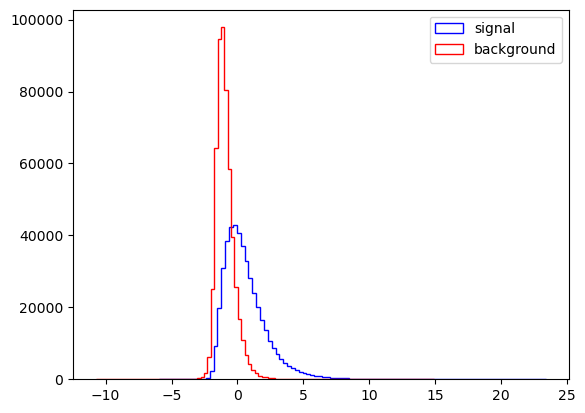

In [6]:
plt.figure()
plt.hist(Fisher.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="blue", label="signal",stacked=True)
plt.hist(Fisher.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="red", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

#### Part a

Compare ROC curves computed on the test versus training samples, in a single plot. Do you see a bias?

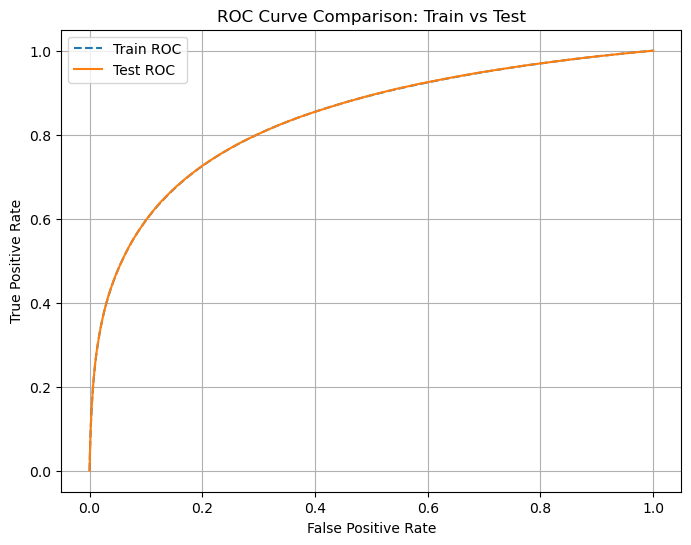

In [7]:
from sklearn.metrics import roc_curve

# Step 1: Compute ROC Curves
fpr_train, tpr_train, _ = roc_curve(y_Train, Fisher.decision_function(X_Train))
fpr_test, tpr_test, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))

# Step 1: Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label="Train ROC", linestyle="--")
plt.plot(fpr_test, tpr_test, label="Test ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: Train vs Test")
plt.legend()
plt.grid()
plt.show()


Both the Train ROC and Test ROC curve is same, so it does not indicate any bias rather it indicates a good generalization.

#### Part b

Train the Fisher performance of using the raw, features, and raw+features as input. Compare the performance one a single plot. 

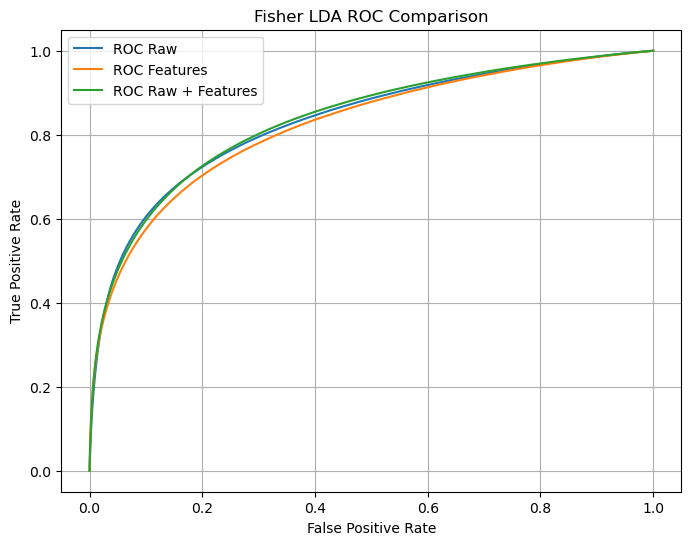

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve

def get_fpr_tpr(X, y):
    model = LinearDiscriminantAnalysis()
    model.fit(X, y)
    fpr, tpr, _ = roc_curve(y, model.decision_function(X))
    return fpr, tpr

# Dictionary of input types
input_types = {
    'Raw': Train_Sample[VarNames[1:9]],
    'Features': Train_Sample[VarNames[9:]],
    'Raw + Features': X_Train
}

y = y_Train

# Plot ROC curves
plt.figure(figsize=(8, 6))
for label, X in input_types.items():
    fpr, tpr = get_fpr_tpr(X, y)
    plt.plot(fpr, tpr, label=f"ROC {label}")

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Fisher LDA ROC Comparison")
plt.grid(True)
plt.show()


### Exercise 4: Comparing Techniques

#### Part a
Select 3 different classifiers from the techniques listed [here](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) to compare. Note that you can use the multi-layer perceptron to build a deep network, though training may be prohibitively slow. So avoid this technique.

Three differentt classifiers:
- SGDClassifier  
- HistGradientBoostingClassifier 
- LogisticRegression
- RandomForestClassifier (

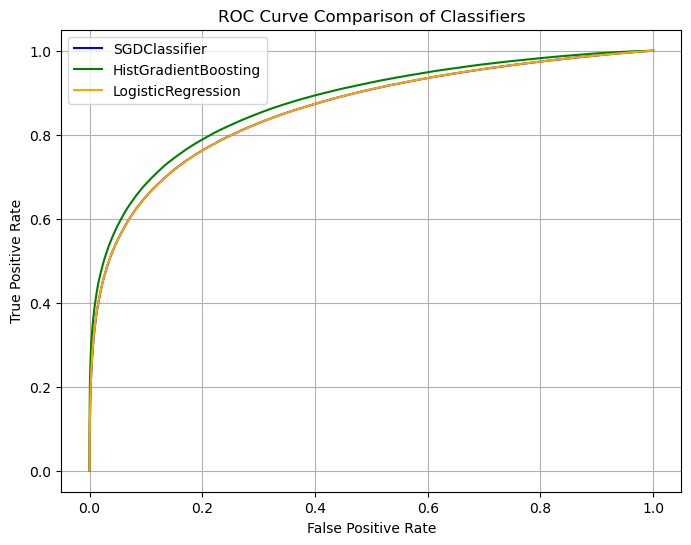

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def compare_classifier(classifiers, X_train, y_train, X_test, y_test, colors=None, plot=True):
    results = {}

    if plot:
        plt.figure(figsize=(8, 6))

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)

        # Get probabilities or decision scores
        if hasattr(clf, "predict_proba"):
            probs = clf.predict_proba(X_test)[:, 1]
        else:
            probs = clf.decision_function(X_test)

        fpr, tpr, _ = roc_curve(y_test, probs)
        results[name] = (fpr, tpr)

        if plot:
            color = colors[name] if colors and name in colors else None
            plt.plot(fpr, tpr, label=name, color=color)

    if plot:
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve Comparison of Classifiers")
        plt.legend()
        plt.grid(True)
        plt.show()
        
    return results

# Define classifiers
classifiers = {
    "SGDClassifier": SGDClassifier(loss="log_loss", max_iter=1000, random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(solver="liblinear", random_state=42)
}

# Define colors (optional)
colors = {
    "SGDClassifier": "blue",
    "HistGradientBoosting": "green",
    "LogisticRegression": "orange"
}

# Call the function
results = compare_classifier(classifiers, X_Train, y_Train, X_Test, y_Test, colors=colors, plot=True)

# Access FPR and TPR
fpr_sgd, tpr_sgd = results["SGDClassifier"]

#### Part b

Write a function that takes an instantiated classifier and performs the comparison from part 3b. Use the function on your choice of functions in part a.

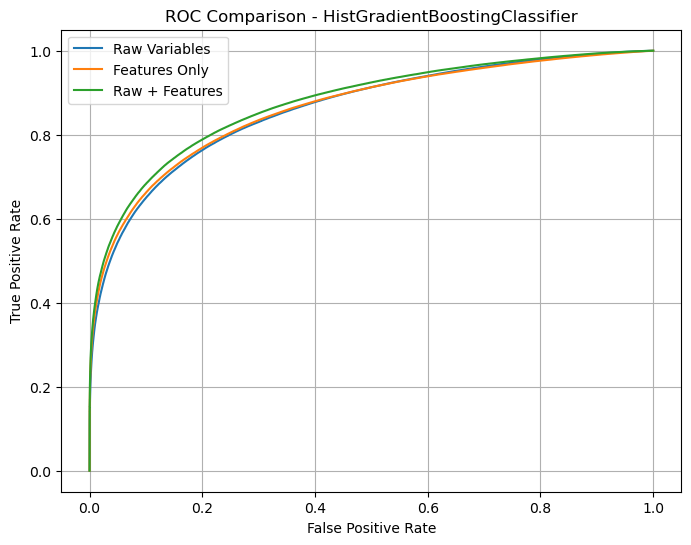

In [22]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def plot_roc_by_input_type(classifier, Train_Sample, X_Test, y_Test, VarNames):

    X_raw = Train_Sample[VarNames[1:9]]
    X_feat = Train_Sample[VarNames[9:]]
    X_both = Train_Sample[VarNames[1:]]
    y = Train_Sample['signal']

    # Train and predict on Raw
    classifier.fit(X_raw, y)
    probs_raw = classifier.predict_proba(X_Test[VarNames[1:9]])[:, 1]
    fpr_raw, tpr_raw, _ = roc_curve(y_Test, probs_raw)

    # Train and predict on Features
    classifier.fit(X_feat, y)
    probs_feat = classifier.predict_proba(X_Test[VarNames[9:]])[:, 1]
    fpr_feat, tpr_feat, _ = roc_curve(y_Test, probs_feat)

    # Train and predict on Raw + Features
    classifier.fit(X_both, y)
    probs_both = classifier.predict_proba(X_Test[VarNames[1:]])[:, 1]
    fpr_both, tpr_both, _ = roc_curve(y_Test, probs_both)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_raw, tpr_raw, label="Raw Variables")
    plt.plot(fpr_feat, tpr_feat, label="Features Only")
    plt.plot(fpr_both, tpr_both, label="Raw + Features")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Comparison - {classifier.__class__.__name__}")
    plt.legend()
    plt.grid()
    plt.show()
    

clf = HistGradientBoostingClassifier(random_state=42)
plot_roc_by_input_type(clf, Train_Sample, X_Test, y_Test, VarNames)


#### Part c

Use the best method from part c to compute the maximal significance $\sigma_S= \frac{N_S}{\sqrt{N_S+N_B}}$ for the scenarios in lab 5.

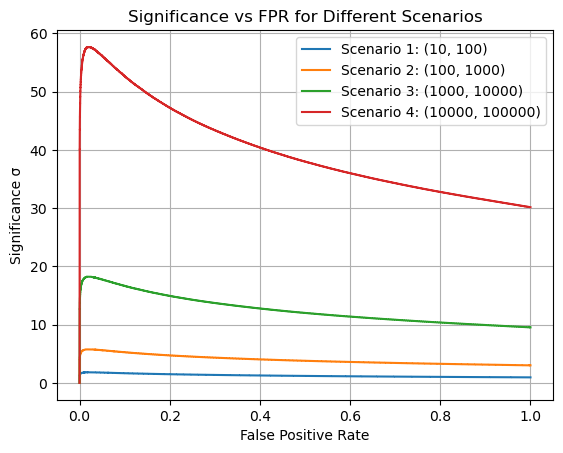

Scenario,N_sig,N_bkg,TPR,FPR,N_sig',N_bkg',Max σ,Threshold Bin
1,10,100,0.463459,0.0182551,4.63459,1.82551,1.82344,18550
2,100,1000,0.463459,0.0182551,46.3459,18.2551,5.76622,18550
3,1000,10000,0.463459,0.0182551,463.459,182.551,18.2344,18550
4,10000,100000,0.463459,0.0182551,4634.59,1825.51,57.6622,18550


{'1': {'index': 18550, 'scaled_signal': 4.634585461981132, 'scaled_background': 1.825508013592559, 'max_significance': 1.8234399277715898}, '2': {'index': 18550, 'scaled_signal': 46.34585461981132, 'scaled_background': 18.25508013592559, 'max_significance': 5.766223749917215}, '3': {'index': 18550, 'scaled_signal': 463.45854619811314, 'scaled_background': 182.5508013592559, 'max_significance': 18.234400674913523}, '4': {'index': 18550, 'scaled_signal': 4634.585461981132, 'scaled_background': 1825.508013592559, 'max_significance': 57.66223794100486}}


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import tabulate


###modify compare_classifier function to  fit
def compare_classifier(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)

    if hasattr(classifier, "predict_proba"):
        probs = classifier.predict_proba(X_test)[:, 1]
    else:
        probs = classifier.decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, probs)
    return fpr, tpr, thresholds


def plot_significance_with_classifier(classifier, X_train, y_train, X_test, y_test, scenarios, bins=100, log=False):
    
    # Get FPR (False Positive Rate) and TPR (True Positive Rate)
    FPR, TPR, _ = compare_classifier(classifier, X_train, y_train, X_test, y_test)

    max_significance_dict = {}
    results_table = []

    # Loop through each scenario and calculate significance
    for scenario_id, (expected_signal, expected_background) in scenarios.items():
        
        # Rescale expected signal and background by TPR and FPR at each threshold
        scaled_signal = expected_signal * TPR
        scaled_background = expected_background * FPR

        # Compute significance at each threshold (small epsilon added for stability)
        significance = scaled_signal / np.sqrt(scaled_signal + scaled_background + 1e-6)

        # Plot the significance curve
        plt.step(FPR, significance, label=f"Scenario {scenario_id}: ({expected_signal}, {expected_background})")

        # Find index of max significance
        max_idx = np.argmax(significance)

        # Store max significance info
        max_info = {
            "index": max_idx,
            "scaled_signal": scaled_signal[max_idx],
            "scaled_background": scaled_background[max_idx],
            "max_significance": significance[max_idx]
        }
        max_significance_dict[scenario_id] = max_info

        # Append row to result table
        results_table.append([
            scenario_id,
            expected_signal,
            expected_background,
            TPR[max_idx],
            FPR[max_idx],
            scaled_signal[max_idx],
            scaled_background[max_idx],
            significance[max_idx],
            max_idx
        ])

    # Plot formatting
    if log:
        plt.yscale("log")

    plt.xlabel("False Positive Rate")
    plt.ylabel("Significance σ")
    plt.title("Significance vs FPR for Different Scenarios")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Display table of results
    headers = ["Scenario", "N_sig", "N_bkg", "TPR", "FPR", "N_sig'", "N_bkg'", "Max σ", "Threshold Bin"]
    display(HTML(tabulate.tabulate(results_table, headers=headers, tablefmt="html")))

    return max_significance_dict


max_significances = plot_significance_with_classifier(
    classifier=clf,
    X_train=X_Train,
    y_train=y_Train,
    X_test=X_Test,
    y_test=y_Test,
    scenarios=scenarios,
    log=False  # Set True if you want log scale
)

# Optionally print the returned dictionary
print(max_significances)

### Exercise 5: Metrics

Scikit-learn provides methods for computing the FPR, TPR, ROC, AUC metrics. For example:

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()


#### Part a
TPR/FPR/ROC/AUC are one way of assessing the quality of a classifier. Read about [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall), [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision), and [F-score](https://en.wikipedia.org/wiki/F-score).

#### Part b
Look through [model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html#) documentation. Using scikit-learns tools, compute TPR, FPR, ROC, AUC, Precision, Recall, F1 score, and accuracy for the method you selected in 4c above and each scenario. Make a nice table, which also includes the maximal significance. 


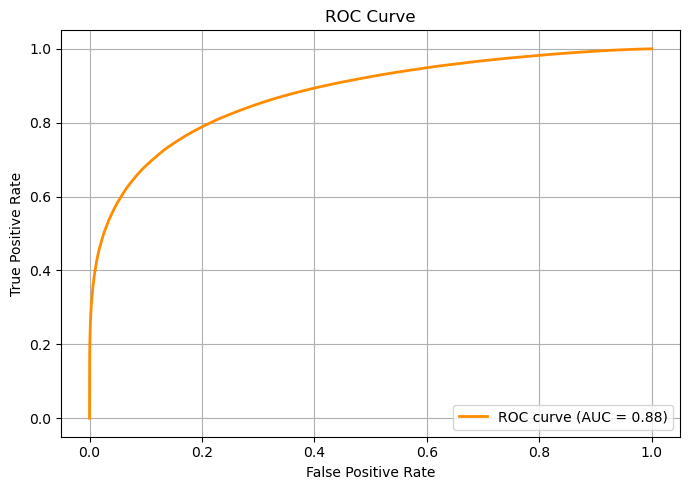

Scenario,N_sig,N_bkg,N_sig',N_bkg',Max σ,TPR,FPR,AUC,Precision,Recall,F1,Accuracy
1,10,100,4.63459,1.82551,1.82344,0.463459,0.0182551,0.875994,0.827441,0.718809,0.769309,0.802458
2,100,1000,46.3459,18.2551,5.76622,0.463459,0.0182551,0.875994,0.827441,0.718809,0.769309,0.802458
3,1000,10000,463.459,182.551,18.2344,0.463459,0.0182551,0.875994,0.827441,0.718809,0.769309,0.802458
4,10000,100000,4634.59,1825.51,57.6622,0.463459,0.0182551,0.875994,0.827441,0.718809,0.769309,0.802458


{'1': {'index': 18550, "N_sig'": 4.634585461981132, "N_bkg'": 1.825508013592559, 'Max σ': 1.8234399277715898}, '2': {'index': 18550, "N_sig'": 46.34585461981132, "N_bkg'": 18.25508013592559, 'Max σ': 5.766223749917215}, '3': {'index': 18550, "N_sig'": 463.45854619811314, "N_bkg'": 182.5508013592559, 'Max σ': 18.234400674913523}, '4': {'index': 18550, "N_sig'": 4634.585461981132, "N_bkg'": 1825.508013592559, 'Max σ': 57.66223794100486}}


In [32]:
from sklearn.metrics import roc_curve, auc, f1_score, precision_score, recall_score, accuracy_score
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import tabulate

def evaluate_classifier_metrics(classifier, X_train, y_train, X_test, y_test, scenarios, log_scale=False):
    # Train the classifier
    classifier.fit(X_train, y_train)

    # Predict scores and class labels
    y_scores = classifier.predict_proba(X_test)[:, 1]
    y_pred = classifier.predict(X_test)

    # ROC metrics
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    auc_score = auc(fpr, tpr)

    # Standard classification metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Prepare table and significance dictionary
    results = []
    max_significance_info = {}

    for scenario_name, (N_sig, N_bkg) in scenarios.items():
        # Scale by TPR and FPR
        N_sig_scaled = N_sig * tpr
        N_bkg_scaled = N_bkg * fpr

        # Compute significance
        significance = N_sig_scaled / np.sqrt(N_sig_scaled + N_bkg_scaled + 1e-6)

        # Max significance
        idx_max = np.argmax(significance)
        max_sig = significance[idx_max]

        max_significance_info[scenario_name] = {
            "index": idx_max,
            "N_sig'": N_sig_scaled[idx_max],
            "N_bkg'": N_bkg_scaled[idx_max],
            "Max σ": max_sig
        }

        # Append row for results table
        results.append([
            scenario_name,
            N_sig,
            N_bkg,
            N_sig_scaled[idx_max],
            N_bkg_scaled[idx_max],
            max_sig,
            tpr[idx_max],
            fpr[idx_max],
            auc_score,
            precision,
            recall,
            f1,
            accuracy
        ])

    # Plot ROC curve
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    if log_scale:
        plt.yscale("log")

    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Display metrics table
    headers = [
        "Scenario", "N_sig", "N_bkg", "N_sig'", "N_bkg'", "Max σ",
        "TPR", "FPR", "AUC", "Precision", "Recall", "F1", "Accuracy"
    ]

    display(HTML(tabulate.tabulate(results, headers=headers, tablefmt="html")))

    return max_significance_info



max_significance_results = evaluate_classifier_metrics(
    classifier=clf,
    X_train=X_Train,
    y_train=y_Train,
    X_test=X_Test,
    y_test=y_Test,
    scenarios=scenarios,
    log_scale=False
)

# Print the returned dictionary if needed
print(max_significance_results)